## Brief description

- In these notebook we are going to evaluate the performance of **Kernel Density Estimation (KDE)** as a method of outlier. detection  
- We are going to consider the uniform - regime test data hightlighted in the presenstation slides.
- The uniform - regime test data is labelled. These labels will help in scoring the model.

## Data description
- **Time Series Stretch** : From 06th March 2022 to 26th March 2022
- **Count** : Total data samples: 5863, Outliers: 101, Normal: 5762

## Outlier detection -  Kernel Density Estimation

### Import the required python packages 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.neighbors import KernelDensity
from matplotlib.dates import DateFormatter
import warnings
warnings. filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 7)

Matplotlib is building the font cache; this may take a moment.


### Test Data Import and Visualization

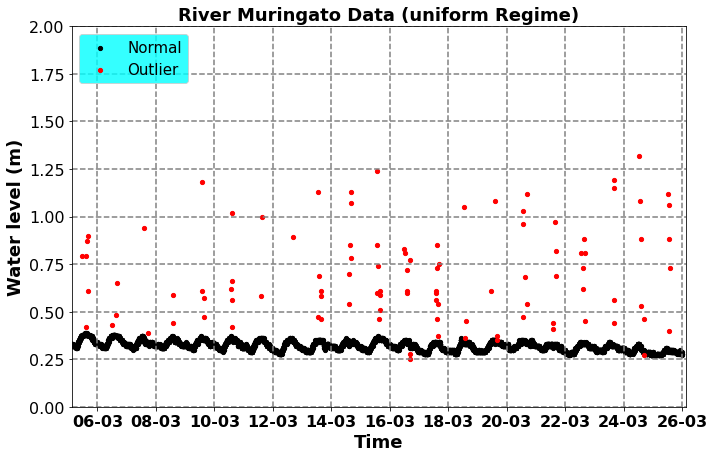

In [4]:
from support import data_visualization_u
df = pd.read_csv('data/uniform_regime.csv')
df[['time']] = df[['time']].apply(pd.to_datetime)
data = data_visualization_u(df)

### Density Estimation 
- When dealing with machine learning applications that involve time series data, we start off with timestamped data$\{x_1,\ldots,x_n\}$.

- The data is assumed to be produced by some data generating process (Sensor node). Mathematically, this data generating process is a probability distribution and we say the $X\sim F_X$..

- This distrubution is often unknown and density estimation aims to determine this distribution. Once the distribution is known it can be used to make inferences.

- The data is discrete (discrete random variables)

#### The histogram
- The histogram is one way to estimate the distribution of the data.
- A histogram is generated by selecting the bin-width $h$ (number of bins) and then counting the number of data samples that fall within a particular bin.


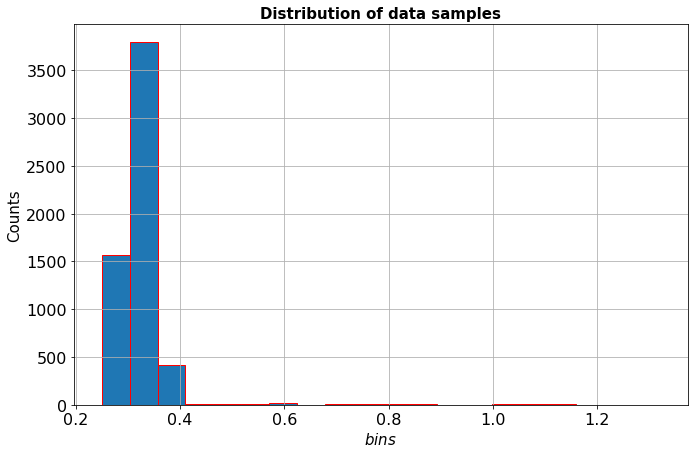

In [5]:
# Lets generate a histogram for the data provided
from support import histogen
histo1 = histogen(df['height'])

### **Improving the estimate**
1. The histogram is similar to a density estimate of the form
\begin{equation}
\hat{f}(x_0)=\frac{\#x_i\in\mathcal{N}(x_0)}{nh}
\end{equation}

    - Where $\mathcal{N}(x_0)$ is a small neigbourhood around $x_0$ of width $h$.
    - $n$ datapoint count
2. As we have seen, this estimate is disjointed. To create a smooth estimate we use (continuity and smoothness )
\begin{equation}
\hat{f}(x_0)=\frac{1}{nh}\sum_{i=1}^n K_h(x_0, x_i)
\end{equation}
![kernel8.PNG](img/kernel8.PNG)

3. Where $K_h(x_0, x_i)$ is the Gaussian kernel which weights the contribution of each of the data points with those close to $x_0$ having a significant contribution. We have
\begin{equation}
K_h(x_0, x_i)  = \frac{1}{\sqrt{2\pi}}e^{-(x_0-x_i)^2/2h^2}
\end{equation}
4. Other kernels that can be utilized are **Tophat, Cosine, Exponential, Linear**
5. Properties of the kernel funtions
    - Non-negative : $K_h(x_0, x_i)> 0$ for every $x$
    - Symmetric
    - Decreasing :  $K_h(x_0, x_i)'< 0$ 
    
6. Using Kernels, linearly inseparable data (provided) can be turned to linearly separable data. Using the PDF the original      non-linear data samples are mapped into a higher-dimensional space in which they are separable
![kernel6.PNG](img/kernel6.PNG)

7. **The Kernel Bandwidth** $h$ : This is a hyperparameter used to determine the width of the kernel. Controls the trade off between the *variance and bias* 
    - High bandwidth - Smooth and high bias density distribution
    - Low bandwidth - Rugged, unsmooth and high variance density distribution
8. The bandwith can be calculated using various method such as the Scotts Rule, Silvermann's Rules

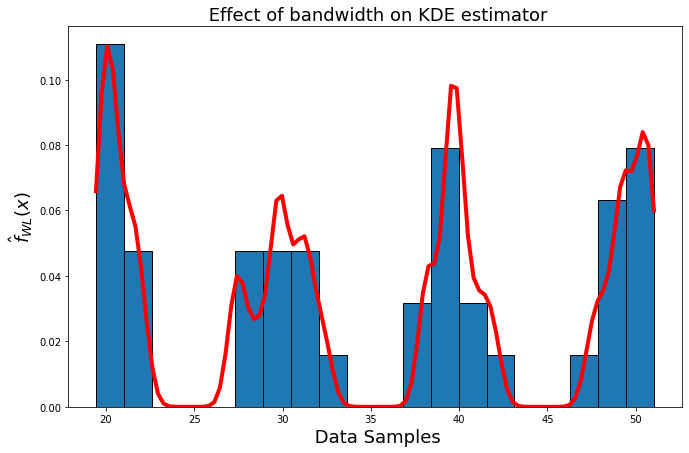

In [6]:
from support import bandwidth_test
band_test = bandwidth_test(0.5) # try (0.1, 0.2, 0.5, 1, 2, 3 ,4)

### Kernel density Estimation (Scikit-learn ) 

#### Bandwidth calculation (Silverman's rule) : Data is unimodal but not symmetric

In [7]:
#calculate interquartile range 
data_samples = np.array(df.height)
q3, q1 = np.percentile(data_samples, [75 ,25])
iqr = q3 - q1
# calculate the standard deviation
strd = np.std(data_samples)
# calculate the bandwidth
h_band = 0.9 * min(iqr, strd) * (len(data_samples) ** -0.2) 
h_band

0.00634860814467009

#### Fit the data samples to the algorithm 

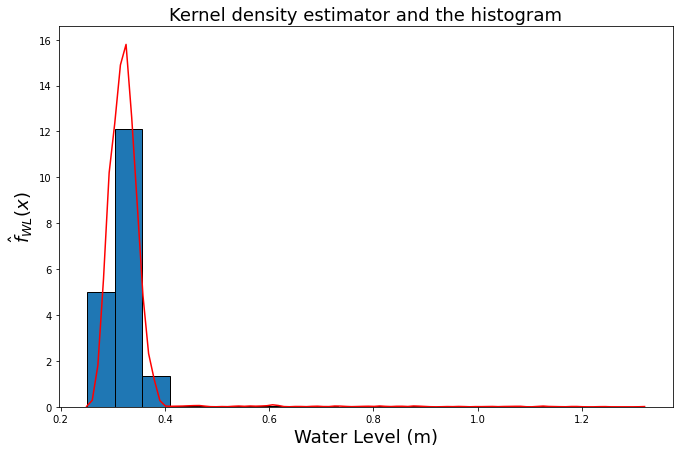

In [8]:
# for the bandwidth slot try (0.01, 0.03, 0.05, 0.08, 0.09, 0.1, 0.15) and observe the change
kde_model = KernelDensity(kernel="gaussian", bandwidth = h_band).fit(data_samples.reshape(-1, 1))
data_sample_plot = np.linspace(np.min(data_samples),np.max(data_samples),100)
log_density = kde_model.score_samples(data_sample_plot.reshape(-1, 1))

plt.hist(data_samples, 20, edgecolor = 'black', density=True);
plt.title('Kernel density estimator and the histogram', fontsize=18)
plt.xlabel('Water Level (m)', fontsize=18)
plt.ylabel(r'$\hat{f}_{WL}(x)$', fontsize=18)
plt.plot(data_sample_plot, np.exp(log_density), color = 'r')

### Outlier detection 

Anomalies are data values that have low probability under the distribution of the data of interest. Using information theoretic ideas, anomalies are surprising and we can measure this by defining the surprise as 

\begin{equation}
s(x) = -\log(f(x))
\end{equation}

We see that:
1. $s(x) = \infty$  when $f(x) = 0$
2. $s(x) = 0$  when $f(x) = 1$


### Example
We generate data from the standard normal and introduce anomalies from $\mathcal{N}(5,2)$. For the standard normal, the surprise is given by

\begin{equation}
s(x)=\log(2\pi)+\frac{x^2}{2}
\end{equation}

Text(0, 0.5, '$s(x)$')

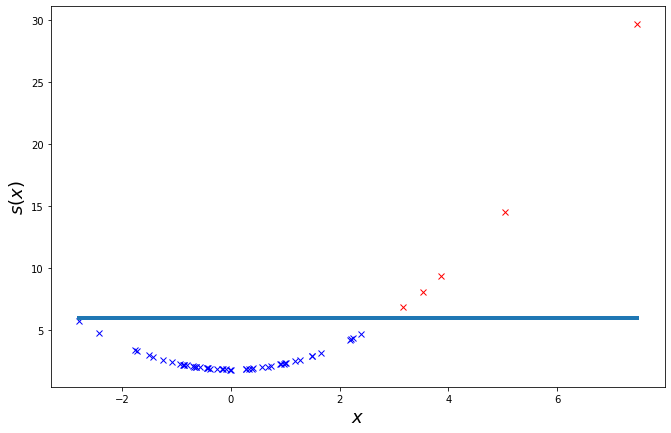

In [9]:
# DATASET: GAUSSIAN DISTRIBUTION ------ MEAN OF 5 AND VARIANCE OF 2
np.random.seed(123)
true = np.random.randn(50)
anomaly = 5 + np.sqrt(2) * np.random.randn(5)

x = np.linspace(np.min([np.min(true), np.min(anomaly)]),
                np.max([np.max(true), np.max(anomaly)]),
                100)

plt.plot(np.sort(true), 
         np.log(2 * np.pi) + (.5 * np.sort(true) ** 2), 
         'bx')

plt.plot(np.sort(anomaly), 
         np.log(2 * np.pi) + (.5 * np.sort(anomaly) ** 2), 
         'rx')

plt.plot(x, [6] * len(x), linewidth=4)
plt.xlabel(r'$x$', fontsize=18)
plt.ylabel(r'$s(x)$', fontsize=18)

### Muringato surprise score 

We will use kde to estimate the density of the water level distribition $\hat{f}_{WL}(x)$. Once we have this distribution we compute the **SURPRISE SCORE** associated with each sample as 

\begin{equation}
s_{WL}(x) = -\log(\hat{f}_{WL}(x))
\end{equation}

In [10]:
surprise = -kde_model.score_samples(data_samples.reshape(-1, 1))


In [11]:
surprise_list = list(surprise)
surprise_threshold = 0
clusters =[]
for i in surprise_list:
    if i < surprise_threshold:
        cluster = 0
    else:
        cluster = 1
    clusters.append(cluster) 

In [12]:
df['kde_label'] = clusters
from support import data_visualization_result_u
#result = data_visualization_result_u(df)

### Scoring the model
- Recall, F1-score, Accuracy, Precision

In [13]:
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
data_labels, kde_labels  = list(df['data_label']), list(df['kde_label'])

Text(0, 0.5, 'True Label')

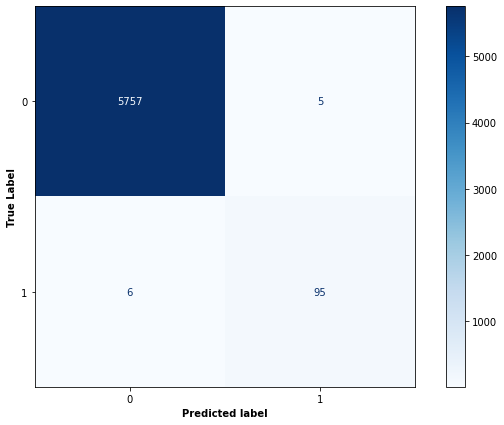

In [14]:
c_matrix = confusion_matrix (data_labels,kde_labels)
disp = ConfusionMatrixDisplay(c_matrix )
disp.plot(cmap=plt.cm.Blues,values_format='g',)
plt.xlabel('Predicted label', weight = 'bold')
plt.ylabel('True Label', weight = 'bold')

In [15]:
model_accuracy = accuracy_score (data_labels,kde_labels)
model_precision = precision_score (data_labels,kde_labels)
model_recall_score = recall_score (data_labels,kde_labels)
model_f1_score = f1_score (data_labels,kde_labels)
print('Accuracy :',model_accuracy,'\nPrecision :',model_precision,'\nRecall :',model_recall_score,'\nF1_score :',model_f1_score)

Accuracy : 0.99812382739212 
Precision : 0.95 
Recall : 0.9405940594059405 
F1_score : 0.9452736318407959
